In [1]:
import argparse
import sys
from tqdm import tqdm

from transformers import CLIPVisionModelWithProjection, AutoTokenizer, AutoModelForCausalLM
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler

import wandb

from param_count import save_param_count_txt

DEVICE = torch.device('cuda:0')

%load_ext autoreload
%autoreload 2   

## 1. Dataset

In [2]:
from dataset import CLIPTextEmbedsKandinskyV22

In [3]:
bs = 48

In [4]:
ds_train = CLIPTextEmbedsKandinskyV22(device=DEVICE)
train_dataloader = DataLoader(ds_train, batch_size=bs, shuffle=True)
print('ds_size', len(ds_train))
print('num_of_batches', len(train_dataloader))

1/3 | COCO-captions dataset is loaded.
2/3 | CLIPVisionModelWithProjection is loaded.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

3/3 | KandinskyV22PriorPipeline is loaded.
ds_size 414010
num_of_batches 8626


## 2. Prepare model

In [2]:
from tiny_gill import prepare_lm_and_tokenizer

In [3]:
num_img_tokens = 4

In [4]:
lm_extended, tokenizer_extended, img_tokens_vocab_idx = prepare_lm_and_tokenizer(device=DEVICE, num_img_tokens=num_img_tokens)


IMG tokens vocabulary indices: [32000, 32001, 32002, 32003]


## 3. Train loop

In [5]:
accum_steps = 5
loss_variant = 'both' # / 'promt_emb_only' / 'hidden_states_only'
lr_base = 1e-3
lr_min = 1e-4
lr_period = 4200
projection_method = 'CLIP-like' # / "sum"

In [6]:
from tiny_gill import TinyGILL

model = TinyGILL(
    lm_extended,
    img_tokens_vocab_idx,
    in_dim=2048,
    out_dim=1280,
    projection_method=projection_method,
    pad_token_id=tokenizer_extended.pad_token_id,
    device=DEVICE,
).half().to(DEVICE)

# Freezing the LM & Unfreezing LM Embedding matrix
model.lm.eval()
for param in model.lm.parameters():
    param.requires_grad = False
model.lm.model.embed_tokens.weight.requires_grad = True 

save_param_count_txt(model, log_dir = './')

In [ ]:
wandb.init(project="LLM2CLIP")

In [8]:
import gc

torch.cuda.empty_cache()
gc.collect()

3255

In [ ]:
from train import train_epoch

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr_base, eps=1e-3)
scheduler = CosineAnnealingLR(optimizer, lr_period, eta_min=lr_min, last_epoch=-1)

model.train()
train_epoch(
    train_dataloader, 
    model, 
    tokenizer_extended,
    img_tokens_vocab_idx,
    loss_fn,
    scheduler,
    optimizer,
    accum_steps=accum_steps, 
    loss_variant=loss_variant, 
    num_img_tokens=num_img_tokens,
    log_to_wandb=True,
    )

In [ ]:
# torch.save(model.state_dict(), f'./wghts-{wandb.run.name}')

In [19]:
# model.load_state_dict(torch.load('./wghts-vivid-fog-54'))

<All keys matched successfully>

## 4. Generation

In [68]:
from generate import create_generator

In [69]:
user_prompt = 'A bathroom with a small white toilet sitting next to a walk.'

In [65]:
kandinsky = create_generator()
img_kandinsky = kandinsky(user_prompt)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

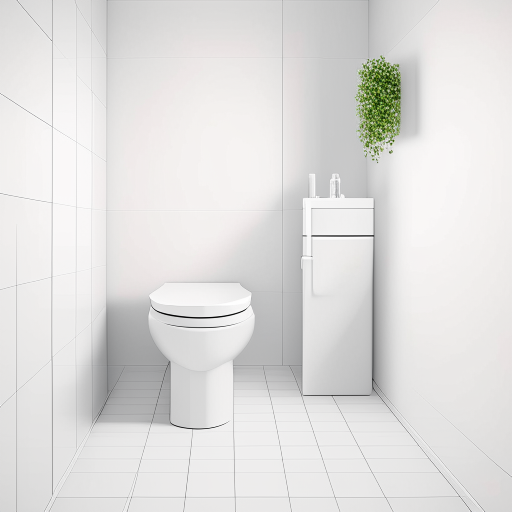

In [66]:
img_kandinsky

In [70]:
tinygill = create_generator(model, tokenizer_extended)
img_tinygill = tinygill(user_prompt)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

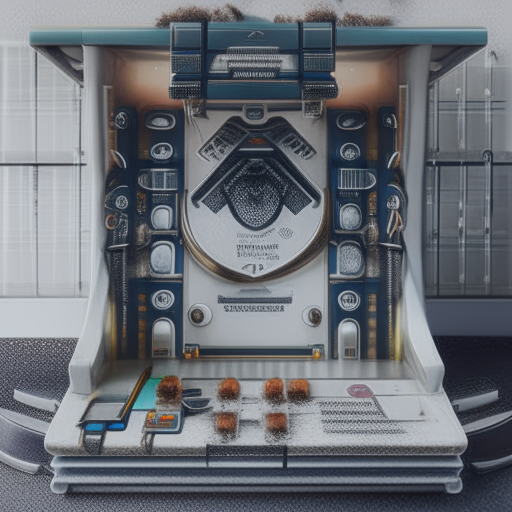

In [73]:
img_tinygill